# FEM, HiDeNN-FEM, and C-HiDeNN (or C-FEM) Tutorial with Python JAX library

### This program solves 1D linear elastic FEM.
### Coded with Jax library. By default, all variables are stored and computed in GPU machine
### Variables ending with _host means that they are stored in CPU memory.
### Codes by Chanwook Park (chanwookpark2024@u.northwestern.edu)


Import libraries

In [1]:
import numpy as onp
from scipy.sparse import csc_matrix
import jax
import jax.numpy as np
from jax.experimental.sparse import BCOO
import time
from itertools import combinations
import math
from functools import partial
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this for memory pre-allocation
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from jax.config import config
config.update("jax_enable_x64", True)

onp.set_printoptions(threshold=sys.maxsize, linewidth=1000, suppress=True, precision=4)

# Pre-processing

Gauss quadratures


In [2]:
def GaussSet(Gauss_Num = 2, cuda=False):
    if Gauss_Num == 2:
        Gauss_Weight1D = [1, 1]
        Gauss_Point1D = [-1/np.sqrt(3), 1/np.sqrt(3)]
       
    elif Gauss_Num == 3:
        Gauss_Weight1D = [0.55555556, 0.88888889, 0.55555556]
        Gauss_Point1D = [-0.7745966, 0, 0.7745966]
       
        
    elif Gauss_Num == 4:
        Gauss_Weight1D = [0.3478548451374538, 0.6521451548625461, 0.6521451548625461, 0.3478548451374538]
        Gauss_Point1D = [-0.8611363115940526, -0.3399810435848563, 0.3399810435848563, 0.8611363115940526]

    elif Gauss_Num == 6: # double checked, 16 digits
        Gauss_Weight1D = [0.1713244923791704, 0.3607615730481386, 0.4679139345726910, 
                          0.4679139345726910, 0.3607615730481386, 0.1713244923791704]
        Gauss_Point1D = [-0.9324695142031521, -0.6612093864662645, -0.2386191860831969, 
                         0.2386191860831969, 0.6612093864662645, 0.9324695142031521]

       
    elif Gauss_Num == 8: # double checked, 20 digits
        Gauss_Weight1D=[0.10122853629037625915, 0.22238103445337447054, 0.31370664587788728733, 0.36268378337836198296,
                        0.36268378337836198296, 0.31370664587788728733, 0.22238103445337447054,0.10122853629037625915]
        Gauss_Point1D=[-0.960289856497536231684, -0.796666477413626739592,-0.525532409916328985818, -0.183434642495649804939,
                        0.183434642495649804939,  0.525532409916328985818, 0.796666477413626739592,  0.960289856497536231684]
        
    elif Gauss_Num == 10:
        Gauss_Weight1D=[0.0666713443086881, 0.1494513491505806, 0.2190863625159820, 0.2692667193099963, 0.2955242247147529,
                        0.2955242247147529, 0.2692667193099963, 0.2190863625159820, 0.1494513491505806, 0.0666713443086881]
        Gauss_Point1D=[-0.9739065285171717, -0.8650633666889845, -0.6794095682990244, -0.4333953941292472, -0.1488743389816312,  
                        0.1488743389816312,  0.4333953941292472,  0.6794095682990244,  0.8650633666889845,  0.9739065285171717]
        
    elif Gauss_Num == 20:
        Gauss_Weight1D=[0.017614007, 0.04060143, 0.062672048, 0.083276742,0.10193012, 0.118194532,0.131688638,
                        0.142096109, 0.149172986, 0.152753387,0.152753387,0.149172986, 0.142096109, 0.131688638,
                        0.118194532,0.10193012, 0.083276742,0.062672048,0.04060143,0.017614007]
            
        Gauss_Point1D=[-0.993128599, -0.963971927, -0.912234428, -0.839116972, -0.746331906, -0.636053681,
                        -0.510867002, -0.373706089, -0.227785851, -0.076526521, 0.076526521, 0.227785851,
                        0.373706089, 0.510867002, 0.636053681, 0.746331906, 0.839116972, 0.912234428, 0.963971927, 0.993128599]
    
    return Gauss_Weight1D, Gauss_Point1D

Mesh generator

In [3]:
def uniform_mesh(L, nelem_x, dim, nodes_per_elem, elem_type, non_uniform_mesh_bool=False):
    """ Mesh generator
    --- Inputs ---
    L: length of the domain
    nelem_x: number of elements in x-direction
    dim: problem dimension
    nodes_per_elem: number of nodes in one elements
    elem_type: element type
    --- Outputs ---
    XY: nodal coordinates (nnode, dim)
    Elem_nodes: elemental nodes (nelem, nodes_per_elem)
    connectivity: elemental connectivity (nelem, node_per_elem*dim)
    nnode: number of nodes
    dof_global: global degrees of freedom
    """
    
    if elem_type == 'D1LN2N': # 1D 2-node linear element
        nelem = nelem_x
        nnode = nelem+1 # number of nodes
        dof_global = nnode*dim    
        
        ## Nodes ##
        XY = onp.zeros([nnode, dim], dtype=onp.double)
        dx = L/nelem # increment in the x direction
    
        n = 0 # This will allow us to go through rows in NL
        for i in range(1, nelem+2):
            if i == 1 or i == nelem+1: # boundary nodes
                XY[n,0] = (i-1)*dx
            else: # inside nodes
                XY[n,0] = (i-1)*dx
                if non_uniform_mesh_bool:
                     XY[n,0] += onp.random.normal(0,0.2,1)*dx# for x values
            n += 1
            
        ## elements ##
        Elem_nodes = onp.zeros([nelem, nodes_per_elem], dtype=onp.int32)
        for j in range(1, nelem+1):
            Elem_nodes[j-1, 0] = j-1
            Elem_nodes[j-1, 1] = j 
                   
    return XY, Elem_nodes, nelem, nnode, dof_global

Gauss quadrature rule

In [4]:
def get_quad_points(Gauss_Num, dim):
    """ Quadrature point and weight generator
    --- Inputs ---
    --- Outputs ---
    """
    Gauss_Weight1D, Gauss_Point1D = GaussSet(Gauss_Num)
    quad_points, quad_weights = [], []
    
    for ipoint, iweight in zip(Gauss_Point1D, Gauss_Weight1D):
        if dim == 1:
            quad_points.append([ipoint])
            quad_weights.append(iweight)
        else:
            for jpoint, jweight in zip(Gauss_Point1D, Gauss_Weight1D):
                if dim == 2:
                    quad_points.append([ipoint, jpoint])
                    quad_weights.append(iweight * jweight)
                else: # dim == 3
                    for kpoint, kweight in zip(Gauss_Point1D, Gauss_Weight1D):
                        quad_points.append([ipoint, jpoint, kpoint])
                        quad_weights.append(iweight * jweight * kweight)
    
    quad_points = np.array(quad_points) # (quad_degree*dim, dim)
    quad_weights = np.array(quad_weights) # (quad_degree,)
    return quad_points, quad_weights

# FEM

FEM shape function and shape function gradients

In [5]:
def get_shape_val_functions(elem_type):
    """ Shape function generator
    """
    ############ 1D ##################
    if elem_type == 'D1LN2N': # 1D linear element
        f1 = lambda x: 1./2.*(1 - x[0])
        f2 = lambda x: 1./2.*(1 + x[0]) 
        shape_fun = [f1, f2]
    
    return shape_fun

def get_shape_grad_functions(elem_type):
    """ Shape function gradient in the parent domain
    """
    shape_fns = get_shape_val_functions(elem_type)
    return [jax.grad(f) for f in shape_fns]

@partial(jax.jit, static_argnames=['Gauss_Num', 'dim', 'elem_type']) # necessary
def get_shape_vals(Gauss_Num, dim, elem_type):
    """ Meature shape function values at quadrature points
    """
    shape_val_fns = get_shape_val_functions(elem_type)
    quad_points, quad_weights = get_quad_points(Gauss_Num, dim)
    shape_vals = []
    for quad_point in quad_points:
        physical_shape_vals = []
        for shape_val_fn in shape_val_fns:
            physical_shape_val = shape_val_fn(quad_point) 
            physical_shape_vals.append(physical_shape_val)
 
        shape_vals.append(physical_shape_vals)

    shape_vals = np.array(shape_vals) # (quad_num, nodes_per_elem)
    return shape_vals

@partial(jax.jit, static_argnames=['Gauss_Num', 'dim', 'elem_type']) # necessary
def get_shape_grads(Gauss_Num, dim, elem_type, XY, Elem_nodes):
    """ Meature shape function gradient values at quadrature points
    --- Outputs
    shape_grads_physical: shape function gradient in physcial coordinate (nelem, quad_num, nodes_per_elem, dim)
    JxW: Jacobian determinant times Gauss quadrature weights (nelem, quad_num)
    """
    shape_grad_fns = get_shape_grad_functions(elem_type)
    quad_points, quad_weights = get_quad_points(Gauss_Num, dim)
    shape_grads = []
    for quad_point in quad_points:
        physical_shape_grads = []
        for shape_grad_fn in shape_grad_fns:
            physical_shape_grad = shape_grad_fn(quad_point)
            physical_shape_grads.append(physical_shape_grad)
        shape_grads.append(physical_shape_grads)

    shape_grads = np.array(shape_grads) # (quad_num, nodes_per_elem, dim)
    physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
    jacobian_dx_deta = np.sum(physical_coos[:, None, :, :, None] * shape_grads[None, :, :, None, :], axis=2, keepdims=True) # dx/deta
    # (nelem, quad_num, nodes_per_elem, dim, dim) -> (nelem, quad_num, 1, dim, dim)
    
    jacbian_det = np.squeeze(np.linalg.det(jacobian_dx_deta)) # det(J) (nelem, quad_num)
    jacobian_deta_dx = np.linalg.inv(jacobian_dx_deta) # deta/dx (nelem, quad_num, 1, dim, dim)
    shape_grads_physical = (shape_grads[None, :, :, None, :] @ jacobian_deta_dx)[:, :, :, 0, :]
    JxW = jacbian_det * quad_weights[None, :]
    return shape_grads_physical, JxW 

FEM global stiffness and force vector builder

In [6]:
def get_A_b_FEM(XY, Elem_nodes, E, A, Gauss_Num_FEM, dim, elem_type, nodes_per_elem, dof_global):
    """ Compute FEM A matrix (stiffness) and b vector (force)
    """
    quad_num_FEM = Gauss_Num_FEM ** dim
    nelem = len(Elem_nodes)
    
    # A matrix ~ stiffness matrix
    shape_vals = get_shape_vals(Gauss_Num_FEM, dim, elem_type) # (quad_num, nodes_per_elem)  
    shape_grads_physical, JxW = get_shape_grads(Gauss_Num_FEM, dim, elem_type, XY, Elem_nodes)    
    BTB = E[:,None,None,None] * A[:,None,None,None] * np.matmul(shape_grads_physical, np.transpose(shape_grads_physical, (0,1,3,2))) # (nelem, quad_num, nodes_per_elem, nodes_per_elem)
    
    V = np.sum(BTB * JxW[:, :, None, None], axis=(1)).reshape(-1) # (nelem, nodes_per_elem, nodes_per_elem) -> (1 ,)
    I = np.repeat(Elem_nodes, nodes_per_elem, axis=1).reshape(-1)
    J = np.repeat(Elem_nodes, nodes_per_elem, axis=0).reshape(-1)
    A_sp_scipy =  csc_matrix((V, (I, J)), shape=(dof_global, dof_global))  # assemble into sparse matrix
    
    # b vector ~ force vector
    physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
    XYs = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2) # (nelem, quad_num, dim)
    body_force = A[:,None] * vv_b_fun(XYs, L).reshape(nelem, quad_num_FEM) # (nelem, quad_num)
    v_vals = np.repeat(shape_vals[None, :, :], nelem, axis=0) # (nelem, quad_num, nodes_per_elem)
    rhs_vals = np.sum(v_vals * body_force[:,:,None] * JxW[:, :, None], axis=1).reshape(-1) # (nelem, nodes_per_elem) -> (nelem*nodes_per_elem)
    rhs = np.zeros(dof_global, dtype=np.double)
    rhs = rhs.at[Elem_nodes.reshape(-1)].add(rhs_vals)  # assemble 
    return A_sp_scipy, rhs



# HiDeNN-FEM automatic r-adaptivity

In [7]:
def get_PE(u, XY, Elem_nodes, Gauss_Num_FEM, dim, elem_type, nodes_per_elem, dof_global):
    """ Compute potential energy (PE) for HiDeNN-FEM
    """
    quad_num_FEM = Gauss_Num_FEM ** dim
    nelem = len(Elem_nodes)
    
    shape_vals = get_shape_vals(Gauss_Num_FEM, dim, elem_type) # (quad_num, nodes_per_elem)  
    shape_grads_physical, JxW = get_shape_grads(Gauss_Num_FEM, dim, elem_type, XY, Elem_nodes) # (nelem, quad_num, nodes_per_elem, dim)
    
    # Strain energy
    u_coos = np.take(u, Elem_nodes, axis=0) # (nelem, nodes_per_elem)
    Grad_uh = np.squeeze(np.sum(shape_grads_physical[:, :, :, :] * u_coos[:, None, :, None], axis=2)) # (nelem, quad_num)
    U = 0.5 * E * A * np.sum(Grad_uh**2 * JxW) 
    
    # Virtual work
    uh = np.sum(shape_vals[None, :, :] * u_coos[:, None, :], axis=2) # (nelem, quad_num)
    physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
    XYs = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2) # (nelem, quad_num, dim)
    body_force = vv_b_fun(XYs, L).reshape(nelem, quad_num_FEM) # (nelem, quad_num)
    W = np.sum(A * body_force * uh * JxW)
    
    return U - W

# Convolution HiDeNN (or C-FEM)


Compute adjacency matrix of graph theory

In [8]:
def get_adj_mat(Elem_nodes, nnode, s_patch):
    """ Use graph theory to get nodal connectivity information
    --- Outouts ---
    indices, indptr: sparse matrix pointers
    """
    
    # get adjacency matrix of graph theory based on nodal connectivity
    adj_rows, adj_cols = [], []
    # self connection
    for inode in range(nnode):
        adj_rows += [inode]
        adj_cols += [inode]
    
    for ielem, elem_nodes in enumerate(Elem_nodes):
        for (inode, jnode) in combinations(list(elem_nodes), 2):
            adj_rows += [inode, jnode]
            adj_cols += [jnode, inode]
    adj_values = onp.ones(len(adj_rows), dtype=onp.int32)
    adj_rows = onp.array(adj_rows, dtype=onp.int32)
    adj_cols = onp.array(adj_cols, dtype=onp.int32)
    
    # build sparse matrix
    adj_sp = csc_matrix((adj_values, 
                              (adj_rows, adj_cols)),
                            shape = (nnode, nnode))
    adj_s = csc_matrix((adj_values, 
                              (adj_rows, adj_cols)),
                            shape = (nnode, nnode))
    
    # compute s th power of the adjacency matrix to get s th order of connectivity
    for itr in range(s_patch-1):
        adj_s = adj_s.dot(adj_sp)
    
    indices = adj_s.indices
    indptr = adj_s.indptr
    
    return indices, indptr

Get patch information

In [9]:
def get_dex_max(indices, indptr, s_patch, Elem_nodes, nelem, nodes_per_elem, dim): # delete d_c, XY, nnode
    """ Pre-compute the maximum number of elemental patch nodes (edex_max) and nodal patch nodes (ndex_max)
    """    

    edex_max = (2+2*s_patch)**dim # estimated value of edex_max
    edexes = onp.zeros(nelem, dtype=onp.int32) # (num_elements, )
    ndexes = onp.zeros((nelem, nodes_per_elem), dtype=onp.int32) # static, (nelem, nodes_per_elem)
    
    for ielem, elem_nodes in enumerate(Elem_nodes):
        if len(elem_nodes) == 2 and dim == 1: # 1D Linear element
            nodal_patch_nodes0 = indices[ indptr[elem_nodes[0]] : indptr[elem_nodes[0]+1] ] # global index, # node_idx 0
            nodal_patch_nodes1 = indices[ indptr[elem_nodes[1]] : indptr[elem_nodes[1]+1] ] # global index
            ndexes[ielem, :] = onp.array([len(nodal_patch_nodes0),len(nodal_patch_nodes1)])
            elemental_patch_nodes = onp.unique(onp.concatenate((nodal_patch_nodes0, nodal_patch_nodes1)))  
           
        edexes[ielem] = len(elemental_patch_nodes)
    edex_max = onp.max(edexes)
    ndex_max = onp.max(ndexes)
    return edex_max, ndex_max

def get_patch_info(indices, indptr, edex_max, ndex_max, Elem_nodes, nelem, nodes_per_elem, dim): # for block, delete s_patch, d_c, XY
    """ Compute patch information for given elements
    --- Outputs ---
    """    

    # Assign memory to variables
    ## Elemental patch
    Elemental_patch_nodes_st = onp.zeros((nelem, edex_max), dtype=onp.int32) # edex_max should be grater than 100!
    edexes = onp.zeros(nelem, dtype=onp.int32) # (num_elements, )
    ## Nodal patch
    Nodal_patch_nodes_st = (-1)*onp.ones((nelem, nodes_per_elem, ndex_max), dtype=onp.int32) # static, (nelem, nodes_per_elem, ndex_max)
    Nodal_patch_nodes_bool = onp.zeros((nelem, nodes_per_elem, ndex_max), dtype=onp.int32) # static, (nelem, nodes_per_elem, ndex_max)
    Nodal_patch_nodes_idx = (-1)*onp.ones((nelem, nodes_per_elem, ndex_max), dtype=onp.int32) # static, (nelem, nodes_per_elem, ndex_max)
    ndexes = onp.zeros((nelem, nodes_per_elem), dtype=onp.int32) # static, (nelem, nodes_per_elem)
    
    
    for ielem, elem_nodes in enumerate(Elem_nodes):
        
        # 1. for loop: nodal_patch_nodes in global nodal index
        for inode_idx, inode in enumerate(elem_nodes):
            nodal_patch_nodes = onp.sort(indices[ indptr[elem_nodes[inode_idx]] : indptr[elem_nodes[inode_idx]+1] ]) # global index
            ndex = len(nodal_patch_nodes)
            ndexes[ielem, inode_idx] = ndex
            Nodal_patch_nodes_st[ielem, inode_idx, :ndex] = nodal_patch_nodes  # global nodal index
            Nodal_patch_nodes_bool[ielem, inode_idx, :ndex] = onp.where(nodal_patch_nodes>=0, 1, 0)
    
        # 2. get elemental_patch_nodes    
        if len(elem_nodes) == 2 and dim == 1: # 1D Linear element
            elemental_patch_nodes = onp.unique(onp.concatenate((Nodal_patch_nodes_st[ielem, 0, :ndexes[ielem, 0]],
                                                                Nodal_patch_nodes_st[ielem, 1, :ndexes[ielem, 1]])))  # node_idx 1
            
        edex = len(elemental_patch_nodes)
        edexes[ielem] = edex
        Elemental_patch_nodes_st[ielem, :edex] = elemental_patch_nodes
        
        # 3. for loop: get nodal_patch_nodes_idx
        for inode_idx, inode in enumerate(elem_nodes):
            nodal_patch_nodes_idx = onp.searchsorted(
                elemental_patch_nodes, Nodal_patch_nodes_st[ielem, inode_idx, :ndexes[ielem, inode_idx]]) # local index
            Nodal_patch_nodes_idx[ielem, inode_idx, :ndexes[ielem, inode_idx]] = nodal_patch_nodes_idx
   
            
    # Convert everything to device array
    Elemental_patch_nodes_st = np.array(Elemental_patch_nodes_st)
    edexes = np.array(edexes)
    Nodal_patch_nodes_st = np.array(Nodal_patch_nodes_st)
    Nodal_patch_nodes_bool = np.array(Nodal_patch_nodes_bool)
    Nodal_patch_nodes_idx = np.array(Nodal_patch_nodes_idx)
    ndexes = np.array(ndexes)
    
    return Elemental_patch_nodes_st, edexes, Nodal_patch_nodes_st, Nodal_patch_nodes_bool, Nodal_patch_nodes_idx, ndexes

Compute radial basis functions

In [10]:
@partial(jax.jit, static_argnames=['ndex_max','mbasis']) # This will slower the function
def Compute_RadialBasis_1D(xy, xv, ndex, ndex_max, nodal_patch_nodes_bool, 
                         a_dil, mbasis=0):
    """ 
    --- Inputs ---
    # xy: point of interest
    # xv: ndoal coordinates of patch nodes. ()
    # ndex: number of nodse in the nodal patch
    # ndex_max: max of ndex, precomputed value
    # nodal_patch_nodes_bool: boolean vector that tells ~~~
    # a_dil: dilation parameter for cubic spline
    # mbasis: number of polynomial terms
    
    """
    
    RP = np.zeros(ndex_max + mbasis, dtype=np.double)
    for i in range(ndex_max):
        ndex_bool = nodal_patch_nodes_bool[i]
        zI = np.linalg.norm(xy - xv[i])/a_dil # by defining support domain, zI is bounded btw 0 and 1.
        
        bool1 = np.ceil(0.50001-zI) # returns 1 when 0 < zI <= 0.5 and 0 when 0.5 < zI <1
        bool2 = np.ceil(zI-0.50001) # returns 0 when 0 < zI <= 0.5 and 1 when 0.5 < zI <1
        bool3 = np.heaviside(1-zI, 1) # returns 1 when zI <= 1 // 0 when 1 < zI
                
        # Cubic spline
        RP = RP.at[i].add( ((2/3 - 4*zI**2 + 4*zI**3         ) * bool1 +    # phi_i
                            (4/3 - 4*zI + 4*zI**2 - 4/3*zI**3) * bool2) * bool3 * ndex_bool)   # phi_i
        
    if dim == 1:    
        if mbasis > 0: # 1st
            RP = RP.at[ndex].set(1)         # N
            RP = RP.at[ndex+1].set(xy[0])   # N
        if mbasis > 2: # 2nd
            RP = RP.at[ndex+2].set(xy[0]**2)   # N
        if mbasis > 3: # 3nd
            RP = RP.at[ndex+3].set(xy[0]**3)   # N
    
    return RP

@partial(jax.jit, static_argnames=['ndex_max','mbasis']) # This will slower the function
def Compute_RadialBasis(xy, xv, ndex, ndex_max, nodal_patch_nodes_bool, 
                         a_dil, mbasis=0):
    
    RP = np.zeros((ndex_max + mbasis, 1+dim), dtype=np.double)


    for i in range(ndex_max):
        ndex_bool = nodal_patch_nodes_bool[i]
        zI = np.linalg.norm(xy - xv[i])/a_dil # by defining support domain, zI is bounded btw 0 and 1.
        
        bool1 = np.ceil(0.50001-zI) # returns 1 when 0 < zI <= 0.5 and 0 when 0.5 < zI <1
        bool2 = np.ceil(zI-0.50001) # returns 0 when 0 < zI <= 0.5 and 1 when 0.5 < zI <1
        bool3 = np.heaviside(1-zI, 1) # returns 1 when zI <= 1 // 0 when 1 < zI
        
        # Cubic spline
        RP = RP.at[i,0].add( ((2/3 - 4*zI**2 + 4*zI**3         ) * bool1 +    # phi_i
                              (4/3 - 4*zI + 4*zI**2 - 4/3*zI**3) * bool2) * bool3 * ndex_bool)   # phi_i
        dzIdx = (xy[0] - xv[i,0])/(a_dil**2*zI)
        RP = RP.at[i,1].add( ((-8*zI + 12*zI**2   )*dzIdx * bool1 +  # phi_i,x
                              (-4 + 8*zI - 4*zI**2)*dzIdx * bool2) * bool3 * ndex_bool) # phi_i,x
                
    if mbasis > 0: # 1st
        RP = RP.at[ndex,   0].set(1)         # N
        RP = RP.at[ndex+1, 0].set(xy[0])   # N
        
        RP = RP.at[ndex+1, 1].set(1)   # dNdx
        
    if mbasis > 2: # 2nd
        RP = RP.at[ndex+2, 0].set(xy[0]**2)         # N
        RP = RP.at[ndex+2, 1].set(2 * xy[0]   )     # dNdx
        
    if mbasis > 3: # 3nd
        RP = RP.at[ndex+3, 0].set(xy[0]**3)         # N    
        RP = RP.at[ndex+3, 1].set(3 * xy[0]**2)     # dNdx

    return RP

Compute assembled moment matrix G and vectorize

In [11]:
def get_G(ndex, nodal_patch_nodes, nodal_patch_nodes_bool, XY, ndex_max, a_dil, mbasis):
    # nodal_patch_nodes_bool: (ndex_max,)
    G = np.zeros((ndex_max + mbasis, ndex_max + mbasis), dtype=np.double)
    xv = XY[nodal_patch_nodes,:]
    
    # Build RP
    for idx, (X, ndex_bool) in enumerate(zip(xv, nodal_patch_nodes_bool)):

        RP = Compute_RadialBasis_1D(X, xv, ndex, ndex_max, nodal_patch_nodes_bool, 
                                  a_dil, mbasis) # (edex_max,) but only 'ndex+1' nonzero terms
        G = G.at[:,idx].set(RP * ndex_bool)             
    
    # Make symmetric matrix
    G = np.tril(G) + np.triu(G.T, 1)
    
    # Build diagonal terms to nullify dimensions
    for idx, ndex_bool in enumerate(nodal_patch_nodes_bool):
        G = G.at[idx + mbasis, idx + mbasis].add(abs(ndex_bool-1))
    return G # G matrix

vv_get_G = jax.vmap(jax.vmap(get_G, in_axes = (0,0,0,None,None,None,None)), in_axes = (0,0,0,None,None,None,None))

Compute convolution patch function W (or Phi) and vectorize

In [12]:
@partial(jax.jit, static_argnames=['ndex_max','edex_max','a_dil','mbasis','dim']) # must
def get_Phi(G, nodal_patch_nodes, nodal_patch_nodes_bool, nodal_patch_nodes_idx, ndex, shape_val, elem_nodes,
            XY, ndex_max, edex_max, a_dil, mbasis, dim): # 7
    
    xy_elem = XY[elem_nodes,:] # (nodes_per_elem, dim)
    xv = XY[nodal_patch_nodes,:]
    
    xy = np.sum(shape_val[:, None] * xy_elem, axis=0, keepdims=False)
    RP = Compute_RadialBasis(xy, xv, ndex, ndex_max, nodal_patch_nodes_bool, 
                              a_dil, mbasis)
    phi_org = np.linalg.solve(G.T, RP)[:ndex_max,:] * nodal_patch_nodes_bool[:, None]
    phi = np.zeros((edex_max + 1, 1+dim))  # trick, add dummy node at the end
    # print(phi_org.shape)
    phi = phi.at[nodal_patch_nodes_idx, :].set(phi_org) 
    phi = phi[:edex_max,:] # trick, delete dummy node
    
    return phi

vvv_get_Phi = jax.vmap(jax.vmap(jax.vmap(get_Phi, in_axes = (0,0,0,0,0,None,None,None,None,None,None,None,None)), 
                                in_axes = (None,None,None,None,None,0,None,None,None,None,None,None,None)),
                                in_axes = (0,0,0,0,0,None,0,None,None,None,None,None,None))

Compute C-HiDeNN shape function and shape function gradients

In [13]:
def get_CFEM_shape_fun(elem_idx, nelem_per,
                       XY, XY_host, Elem_nodes, Elem_nodes_host, shape_vals, Gauss_Num, dim, elem_type, nodes_per_elem,
                       indices, indptr, s_patch, edex_max, ndex_max,
                        a_dil, mbasis):
    
    # Define parameters
    quad_num = Gauss_Num**dim
    elem_idx_host = onp.array(elem_idx) # cpu
    elem_idx = np.array(elem_idx) # gpu
    Elem_nodes_host = Elem_nodes_host[elem_idx_host] # cpu
    Elem_nodes = Elem_nodes[elem_idx] # gpu
    shape_grads_physical, JxW = get_shape_grads(Gauss_Num, dim, elem_type, XY, Elem_nodes) # gpu
    
    # Get patch information
    (Elemental_patch_nodes_st, edexes,
     Nodal_patch_nodes_st, Nodal_patch_nodes_bool, Nodal_patch_nodes_idx, ndexes
     ) = get_patch_info(indices, indptr, edex_max, ndex_max, Elem_nodes_host, nelem_per, nodes_per_elem, dim)                         
    
    # Compute assembled moment matrix G
    Gs = vv_get_G(ndexes, Nodal_patch_nodes_st, Nodal_patch_nodes_bool, XY, ndex_max, a_dil, mbasis)
    # Gs: (nelem, nodes_per_elem, ndex_max+mbasis, ndex_max+mbasis)
    
    
    # Compute convolution patch functions W
    # Phi: [nelem_per, quad_num, nodes_per_elem, edex_max, 1+dim]
    Phi = vvv_get_Phi(Gs, Nodal_patch_nodes_st, Nodal_patch_nodes_bool, Nodal_patch_nodes_idx, ndexes, shape_vals, Elem_nodes,
                XY, ndex_max, edex_max, a_dil, mbasis, dim)
    N_til = np.sum(shape_vals[None, :, :, None]*Phi[:,:,:,:,0], axis=2) # (nelem, quad_num, edex_max)
    Grad_N_til = (np.sum(shape_grads_physical[:, :, :, None, :]*Phi[:,:,:,:,:1], axis=2) 
                      + np.sum(shape_vals[None, :, :, None, None]*Phi[:,:,:,:,1:], axis=2) )
    
    # Check partition of unity
    if not ( np.allclose(np.sum(N_til, axis=2), np.ones((nelem_per, quad_num), dtype=np.double)) and
            np.allclose(np.sum(Grad_N_til, axis=2), np.zeros((nelem_per, quad_num, dim), dtype=np.double)) ):
        print(f"PoU Check failed at element {elem_idx[0]}~{elem_idx[-1]}")
        PoU_Check_N = (np.linalg.norm(np.sum(N_til, axis=2) - np.ones((nelem_per, quad_num), dtype=np.float64))**2/(nelem_per*quad_num))**0.5
        PoU_Check_Grad_N = (np.linalg.norm(np.sum(Grad_N_til, axis=2))**2/(nelem_per*quad_num*dim))**0.5
        print(f'PoU check N / Grad_N: {PoU_Check_N:.4e} / {PoU_Check_Grad_N:.4e}')
        
    return N_til, Grad_N_til, JxW, Elemental_patch_nodes_st, Elem_nodes


CFEM global stiffness and force vector builder

In [14]:
def get_A_b_CFEM(XY, XY_host, Elem_nodes, Elem_nodes_host, E, A, Gauss_Num_CFEM, dim, elem_type, nodes_per_elem,
                indices, indptr, s_patch, edex_max, ndex_max, a_dil, mbasis):

    quad_num_CFEM = Gauss_Num_CFEM**dim
    nelem = len(Elem_nodes)
    dof_global = len(XY)*dim
    shape_vals = get_shape_vals(Gauss_Num_CFEM, dim, elem_type) # (quad_num, nodes_per_elem)  
    
    # A matrix ~ stiffness matrix
    (N_til, Grad_N_til, JxW, 
     Elemental_patch_nodes_st, Elem_nodes) = get_CFEM_shape_fun(onp.arange(nelem), nelem,
               XY, XY_host, Elem_nodes, Elem_nodes_host, shape_vals, Gauss_Num_CFEM, dim, elem_type, nodes_per_elem,
               indices, indptr, s_patch, edex_max, ndex_max,
                a_dil, mbasis)
    
    BTB = E[:,None,None,None] * A[:,None,None,None] * np.matmul(Grad_N_til, np.transpose(Grad_N_til, (0,1,3,2))) # (nelem, quad_num, edex_max, edex_max)
    V = np.sum(BTB * JxW[:, :, None, None], axis=(1)).reshape(-1) # (nelem, nodes_per_elem, nodes_per_elem) -> (1 ,)
    I = np.repeat(Elemental_patch_nodes_st, edex_max, axis=1).reshape(-1)
    J = np.repeat(Elemental_patch_nodes_st, edex_max, axis=0).reshape(-1)
    A_sp_scipy =  csc_matrix((V, (I, J)), shape=(dof_global, dof_global)) 
    
    # b vector ~ force vector
    physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
    XYs = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2)
    body_force = A[:,None] * vv_b_fun(XYs, L).reshape(nelem, quad_num_CFEM)
    rhs_vals = np.sum(N_til * body_force[:,:,None] * JxW[:, :, None], axis=1).reshape(-1) # (nelem, nodes_per_elem) -> (nelem*nodes_per_elem)
    rhs = np.zeros(dof_global, dtype=np.double)
    rhs = rhs.at[Elemental_patch_nodes_st.reshape(-1)].add(rhs_vals)  # assemble 
    
    return A_sp_scipy, rhs


# Error analysis

In [15]:
def get_FEM_norm(XY, Elem_nodes, u, Gauss_Num_norm, dim, elem_type):

    """ Variables
    L2_nom: (nelem, quad_num)
    L2_denom: (nelem, quad_num)
    H1_nom: (nelem, quad_num)
    H1_denom: (nelem, quad_num)
    XY_norm: (nelem, quad_num, dim)
    u_exact: (nelem, quad_num)
    uh: (nelem, quad_num)
    Grad_u_exact: (nelem, quad_num, dim)
    Grad_uh: (nelem, quad_num, dim) 
    """
    
    quad_num_norm = Gauss_Num_norm**dim
    # L2_nom, L2_denom, H1_nom, H1_denom = 0,0,0,0
    shape_vals = get_shape_vals(Gauss_Num_norm, dim, elem_type) # (quad_num, nodes_per_elem)  
    shape_grads_physical, JxW = get_shape_grads(Gauss_Num_norm, dim, elem_type, XY, Elem_nodes)    
    
    physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
    xy_norm = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2)
    u_exact = vv_u_fun(xy_norm, L).reshape(nelem, quad_num_norm) # (nelem, quad_num)
    Grad_u_exact = vv_Grad_u_fun(xy_norm, L)

    u_coos = np.take(u, Elem_nodes, axis=0) # (nelem, nodes_per_elem)
    uh = np.sum(shape_vals[None, :, :] * u_coos[:, None, :], axis=2)
    Grad_uh = np.sum(shape_grads_physical[:, :, :, :] * u_coos[:, None, :, None], axis=2)
    
    L2_nom = np.sum((u_exact-uh)**2 * JxW)
    L2_denom = np.sum((u_exact)**2 * JxW)
    H1_nom = np.sum(((u_exact-uh)**2 + np.sum((Grad_u_exact-Grad_uh)**2, axis=2)) * JxW)
    H1_denom = np.sum(((u_exact)**2 + np.sum((Grad_u_exact)**2, axis=2)) * JxW)

    L2_norm = (L2_nom/L2_denom)**0.5
    H1_norm = (H1_nom/H1_denom)**0.5
    print(f'L2_norm_FEM: {L2_norm:.4e}')
    print(f'H1_norm_FEM: {H1_norm:.4e}')
    return L2_norm, H1_norm


def get_CFEM_norm(u, XY, XY_host, Elem_nodes, Elem_nodes_host, Gauss_Num_norm, dim, elem_type, nodes_per_elem,
                  indices, indptr, s_patch, edex_max, ndex_max, a_dil, mbasis):

    
    quad_num_norm = Gauss_Num_norm**dim
    shape_vals = get_shape_vals(Gauss_Num_norm, dim, elem_type) # (quad_num, nodes_per_elem)  
    shape_grads_physical, JxW = get_shape_grads(Gauss_Num_norm, dim, elem_type, XY, Elem_nodes)    
    
    (N_til, Grad_N_til, JxW, 
     Elemental_patch_nodes_st, Elem_nodes) = get_CFEM_shape_fun(onp.arange(nelem), nelem,
               XY, XY_host, Elem_nodes, Elem_nodes_host, shape_vals, Gauss_Num_norm, dim, elem_type, nodes_per_elem,
               indices, indptr, s_patch, edex_max, ndex_max, a_dil, mbasis)
                                                                
    physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
    xy_norm = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2)
    u_exact = vv_u_fun(xy_norm, L).reshape(nelem, quad_num_norm)
    Grad_u_exact = vv_Grad_u_fun(xy_norm, L)
    
    u_coos = np.take(u, Elemental_patch_nodes_st, axis=0) # (nelem, nodes_per_elem)
    uh = np.sum(N_til[:, :, :] * u_coos[:, None, :], axis=2)
    Grad_uh = np.sum(Grad_N_til[:, :, :, :] * u_coos[:, None, :, None], axis=2)
    
    L2_nom = np.sum((u_exact-uh)**2 * JxW)
    L2_denom = np.sum((u_exact)**2 * JxW)
    H1_nom = np.sum(((u_exact-uh)**2 + np.sum((Grad_u_exact-Grad_uh)**2, axis=2)) * JxW)
    H1_denom = np.sum(((u_exact)**2 + np.sum((Grad_u_exact)**2, axis=2)) * JxW)

    L2_norm = (L2_nom/L2_denom)**0.5
    H1_norm = (H1_nom/H1_denom)**0.5
    print(f'L2_norm_FEM: {L2_norm:.4e}')
    print(f'H1_norm_FEM: {H1_norm:.4e}')
    return L2_norm, H1_norm


# Solver (conjugate gradient iterative solver)

In [16]:
@jax.jit
def get_residual(sol, A_sp, b, disp_BC_idx):
    res = b - A_sp @ sol
    res = res.at[disp_BC_idx].set(0) # disp. BC
    return res

@jax.jit
def get_Ap(p, A_sp, disp_BC_idx):
    Ap = A_sp @ p
    Ap = Ap.at[disp_BC_idx].set(0) # disp. BC
    return Ap

def CG_solver_PC(M_inv, get_residual, get_Ap, sol, A_sp, b, disp_BC_idx, dof_global, tol):
    # M_inv: inverse of the preconditioner. For my problem, it should be a vector of the diagonal.
    
    start_time = time.time()

    r_old = get_residual(sol, A_sp, b, disp_BC_idx)
    z_old = M_inv * r_old
    p = z_old
    
    for step in range(dof_global*1000000):
        # print(p)
        Ap = get_Ap(p, A_sp, disp_BC_idx)
        alpha = np.dot(r_old, z_old) / np.dot(p, Ap)
        sol += alpha * p
        r_new = r_old - alpha * Ap
        rsnew = np.dot(r_new,r_new)
        if step%1000 == 0:
            print(f"step = {step}, res l_2 = {rsnew**0.5}") 
        
        if rsnew**0.5 < tol:
            
            break
        z_new = M_inv * r_new
        beta = np.dot(r_new, z_new) / np.dot(r_old, z_old)
        p = z_new + beta * p
        
        r_old = r_new
        z_old = z_new
    print(f"CG solver took {time.time() - start_time:.4f} seconds")
    return sol

def Solve(A_sp_scipy, b, dof_global, nodes_per_elem, disp_BC_idx, disp_BC):
    """ Pre-conditioned conjugate-gradient iterative solver implemented on GPU
    """

    tol = 1e-15
    sol = np.zeros(dof_global, dtype=np.double)              # (dof,)
    sol = sol.at[disp_BC_idx].set(disp_BC) # set displacement BC
    
    # preconditioned CG solver
    M = np.array(A_sp_scipy.diagonal())
    M_inv = 1/M
    
    A_sp = BCOO.from_scipy_sparse(A_sp_scipy)
    b = np.array(b)
    sol = CG_solver_PC(M_inv, get_residual, get_Ap, sol, A_sp, b, disp_BC_idx, dof_global, tol)
       
    return sol

# Main program


- - - - - - CFEM D1LN2N DOFs: 5, nelem_x: 4 with s: 2, a: 1000, p: 2 - - - - - -
CFEM adj_s matrix took 0.0018 seconds
edex_max / ndex_max: 5 / 5, took 0.0005 seconds
step = 0, res l_2 = 0.6550959704521528
CG solver took 0.0055 seconds
L2_norm_FEM: 5.9819e-10
H1_norm_FEM: 2.6371e-09


<Figure size 640x480 with 0 Axes>

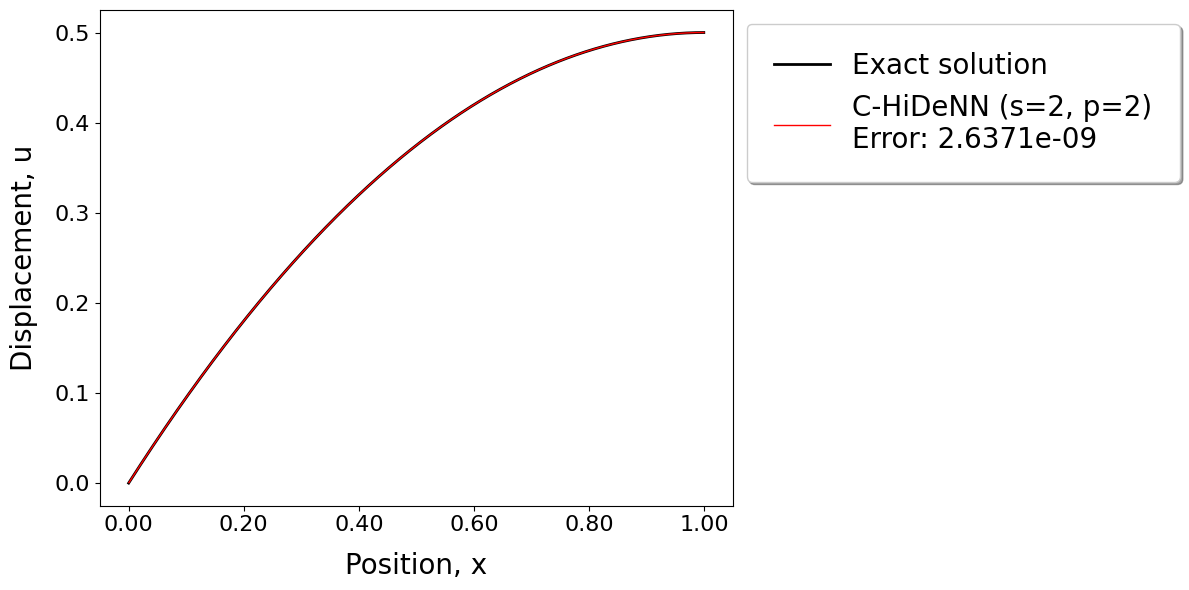

<Figure size 640x480 with 0 Axes>

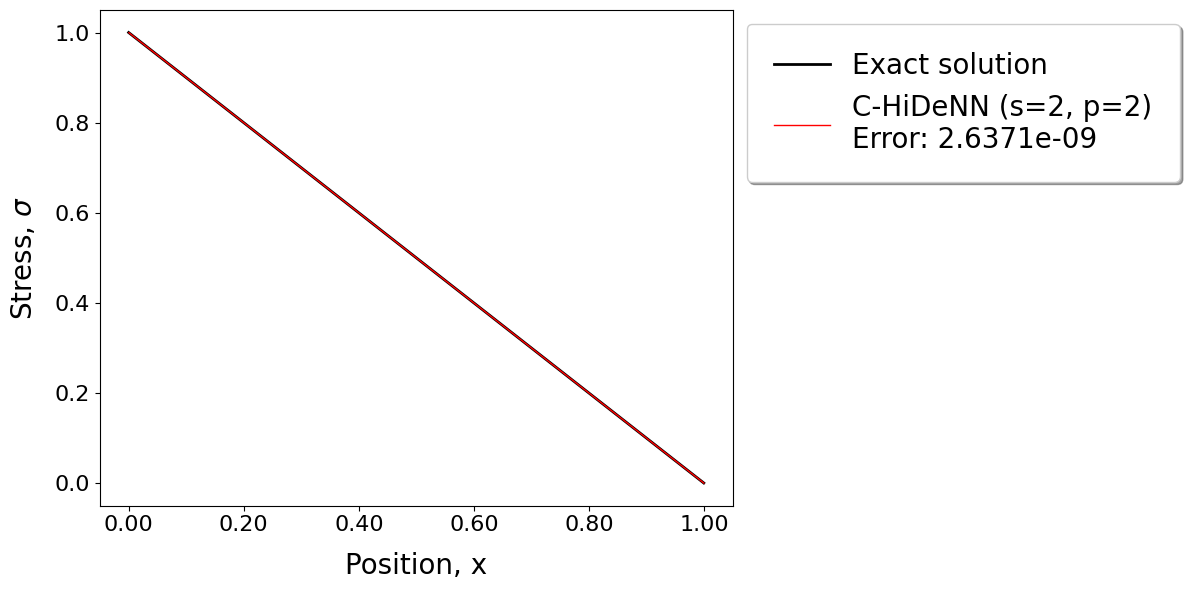

In [27]:
gpu_idx = 3
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

# Problem settings
s_patches = [2]         # patch_size
ps = [-1]               # reproducing polynomial order. [0, 1, 2, 3]. -1 means that p is equal to s.
alpha_dils = [1000]       # dilation parameter
nelems = [4]            # [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
elem_types = ['D1LN2N'] # 'D1LN2N'

run_FEM = False
run_HiDeNN = False
run_CFEM = True

plot_bool = True
non_uniform_mesh_bool = True


# uniform body force
@jax.jit
def u_fun_1D(x, L):
    # x is a scalar, a is a parameter, mostly being np.pi
    u = 1/2*(2*L*x-x**2)
    return u

@jax.jit
def Grad_u_fun_1D(x, L):
    # x is a scalar, a is a parameter, mostly being np.pi
    dudx = (L-x)
    return dudx

@jax.jit
def b_fun_1D(x, L):
    # x is a scalar, a is a parameter, mostly being np.pi
    b = 1
    return b

F = 0 # traction force at the right end

## Properties
L = 1 # length of the domain
E = 1 # Young's modulus
A = 1 # Cross-section area

#%%
for elem_type in elem_types:
    nodes_per_elem = int(elem_type[4:-1])
    dim = int(elem_type[1])
    elem_dof = nodes_per_elem*dim    
    
    p_dict={0:0, 1:2, 2:3, 3:4} 
    u_fun = u_fun_1D
    vv_b_fun = jax.vmap(jax.vmap(b_fun_1D, in_axes = (0, None)), in_axes = (0, None))
    vv_u_fun = jax.vmap(jax.vmap(u_fun_1D, in_axes = (0, None)), in_axes = (0, None))
    vv_Grad_u_fun = jax.vmap(jax.vmap(Grad_u_fun_1D, in_axes = (0, None)), in_axes = (0, None))
    Gauss_Num_FEM = 8 # 6
    Gauss_Num_CFEM = 8  # 6
    Gauss_Num_norm = 20  # 8 or higher is enough
    
    for s_patch in s_patches:
        for p in ps: # polynomial orders
            if p == -1:
                p = s_patch
            mbasis = p_dict[p]  
            for alpha_dil in alpha_dils:
                for nelem_x in nelems:
                    
                    # Problem setting
                    
                    
                    
                    ## Mesh generation
                    XY_host, Elem_nodes_host, nelem, nnode, dof_global = uniform_mesh(L, nelem_x, dim, nodes_per_elem, 
                                                                                      elem_type, non_uniform_mesh_bool)
                    Es = np.ones(nelem, dtype=np.double) * E
                    As = np.ones(nelem, dtype=np.double) * A
                    
                    ## Displacement boundary condition
                    disp_BC_idx = np.array([0])     # nodal index where the Dirichlet boundary condition is imposed
                    disp_BC = np.array([0], dtype=np.double) # Dirichlet boundary condition value
                    
                    ## host to device array
                    XY = np.array(XY_host)
                    Elem_nodes = np.array(Elem_nodes_host)
                    
                    # Exact solution
                    x_space_exact = np.arange(0,L,0.001)
                    u_exact = onp.zeros_like(x_space_exact)
                    strain_exact = onp.zeros_like(x_space_exact)
                    stress_exact = onp.zeros_like(x_space_exact)
                    for idx, x in enumerate(x_space_exact):
                        u_exact[idx] = u_fun_1D(x, L)
                        strain_exact[idx] = Grad_u_fun_1D(x, L)
                        stress_exact[idx] = E * strain_exact[idx]
                        
                    
                    if run_FEM == True:
                        print(f"\n----------------- FEM elem_tpye: {elem_type}, nelem_x: {nelem_x}, DOFs: {dof_global} --------------------")
                        
                        # Run FEM
                        A_sp_scipy, b = get_A_b_FEM(XY, Elem_nodes, Es, As, Gauss_Num_FEM, dim, elem_type, nodes_per_elem, dof_global)
                        sol = Solve(A_sp_scipy, b, dof_global, nodes_per_elem, disp_BC_idx, disp_BC)
                        
                        # Compute errors
                        L2_norm_FEM, H1_norm_FEM = get_FEM_norm(XY, Elem_nodes, sol, Gauss_Num_norm, dim, elem_type)
                        
                        # Compute Disp, strain, stress field for plotting
                        if plot_bool:
                            shape_vals = get_shape_vals(Gauss_Num_norm, dim, elem_type) # [quad_num_ctr, nodes_per_elem]
                            shape_grads_physical, JxW = get_shape_grads(Gauss_Num_norm, dim, elem_type, XY, Elem_nodes)   
                            physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
                            x_space_FEM = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2).reshape(-1)
                            
                            u_coos = np.take(sol, Elem_nodes, axis=0) # (nelem, nodes_per_elem)
                            disp_FEM = np.sum(shape_vals[None, :, :] * u_coos[:, None, :], axis=2).reshape(-1)
                            strain_FEM = np.sum(shape_grads_physical[:, :, :, :] * u_coos[:, None, :, None], axis=2).reshape(-1)
                            stress_FEM = (Es[:,None,None] * np.sum(shape_grads_physical[:, :, :, :] * u_coos[:, None, :, None], axis=2)).reshape(-1) # (nelem, quad_num, dim) -> (1,)
                    
                        
                    if run_HiDeNN == True:
                        print(f"\n----------------- HiDeNN FEM elem_tpye: {elem_type}, nelem_x: {nelem_x}, DOFs: {dof_global} --------------------")
                        
                        # Settings
                        masking = np.ones(dof_global, dtype=np.int32)
                        masking = masking.at[np.array([0,-1])].set(0)
                        learning_rate = 5
                        max_itr = 10
                        grad_PE = jax.grad(get_PE, argnums=1)
                        
                        
                        # print(XY)
                        for itr in range(max_itr):
                            
                            dPidX = grad_PE(sol, XY, Elem_nodes, Gauss_Num_FEM, dim, elem_type, nodes_per_elem, dof_global)
                            # print(dPidX)
                            XY -= learning_rate * masking[:,None] * dPidX
                            learning_rate *= 0.9
                            # if itr%1 == 0:
                            # PE = get_PE(sol, XY, Elem_nodes, Gauss_Num_FEM, dim, elem_type, nodes_per_elem, dof_global)
                            L2_norm_HiDeNN, H1_norm_HiDeNN = get_FEM_norm(XY, Elem_nodes, sol, Gauss_Num_norm, dim, elem_type)
                            # print(f"At {itr} iter, PE: {PE:.8f}")
                            
                            # Run FEM
                            A_sp_scipy, b = get_A_b_FEM(XY, Elem_nodes, Es, As, Gauss_Num_FEM, dim, elem_type, nodes_per_elem, dof_global)
                            sol = Solve(A_sp_scipy, b, dof_global, nodes_per_elem, disp_BC_idx, disp_BC)
                            
                                
                        # Compute Disp, strain, stress field for plotting
                        if plot_bool:
                            shape_vals = get_shape_vals(Gauss_Num_norm, dim, elem_type) # [quad_num_ctr, nodes_per_elem]
                            shape_grads_physical, JxW = get_shape_grads(Gauss_Num_norm, dim, elem_type, XY, Elem_nodes)   
                            physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
                            x_space_HiDeNN = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2).reshape(-1)
                            
                            u_coos = np.take(sol, Elem_nodes, axis=0) # (nelem, nodes_per_elem)
                            disp_HiDeNN = np.sum(shape_vals[None, :, :] * u_coos[:, None, :], axis=2).reshape(-1)
                            strain_HiDeNN = np.sum(shape_grads_physical[:, :, :, :] * u_coos[:, None, :, None], axis=2).reshape(-1)
                            stress_HiDeNN = (Es[:,None,None] * np.sum(shape_grads_physical[:, :, :, :] * u_coos[:, None, :, None], axis=2)).reshape(-1) # (nelem, quad_num, dim) -> (1,)
                        
                        
                    #%% ########################## CFEM ######################
                    if run_CFEM == True:
                        
                        if elem_type != 'D1LN2N':
                            continue
                        if s_patch*2 > nelem_x: # number of element should be greater than 2*s_patch
                            continue
                        if p > s_patch or p > alpha_dil: # polynomial order should be lower than s_patch
                            continue
                        # compute adjacency matrix - Serial
                        print(f"\n- - - - - - CFEM {elem_type} DOFs: {dof_global}, nelem_x: {nelem_x} with s: {s_patch}, a: {alpha_dil}, p: {p} - - - - - -")  
                        
                        start_time_org = time.time()
                        indices, indptr = get_adj_mat(Elem_nodes_host, nnode, s_patch)
                        print(f"CFEM adj_s matrix took {time.time() - start_time_org:.4f} seconds")
                        
                
                        # patch settings
                        d_c = L/nelem_x         # characteristic length in physical coord.
                        a_dil = alpha_dil * d_c # normalize the dilation parameter in the physical coord.
                        
                        # Compute Elemental patch - Serial code
                        start_time = time.time()
                        edex_max, ndex_max = get_dex_max(indices, indptr, s_patch, Elem_nodes_host, nelem, nodes_per_elem, dim)
                        print(f'edex_max / ndex_max: {edex_max} / {ndex_max}, took {time.time() - start_time:.4f} seconds')
                        
                        # Run CFEM
                        A_sp_scipy, b = get_A_b_CFEM(XY, XY_host, Elem_nodes, Elem_nodes_host, Es, As, Gauss_Num_CFEM, dim, elem_type, nodes_per_elem,
                                                    indices, indptr, s_patch, edex_max, ndex_max,
                                                      a_dil, mbasis)
                        sol = Solve(A_sp_scipy, b, dof_global, nodes_per_elem, disp_BC_idx, disp_BC)
                        
                        # Compute Error
                        L2_norm_CFEM, H1_norm_CFEM = get_CFEM_norm(sol, XY, XY_host, Elem_nodes, Elem_nodes_host, 
                                                                    Gauss_Num_norm, dim, elem_type, nodes_per_elem,
                                                                    indices, indptr, s_patch, edex_max, ndex_max, a_dil, mbasis)
                        
                        # Compute Disp, eps, strain field for plotting
                        if plot_bool:
                            shape_vals = get_shape_vals(Gauss_Num_norm, dim, elem_type) # [quad_num_ctr, nodes_per_elem]
                            physical_coos = np.take(XY, Elem_nodes, axis=0) # (nelem, nodes_per_elem, dim)
                            x_space_CFEM = np.sum(shape_vals[None, :, :, None] * physical_coos[:, None, :, :], axis=2).reshape(-1)
                            
                            (N_til, Grad_N_til, JxW, 
                             Elemental_patch_nodes_st, Elem_nodes) = get_CFEM_shape_fun(onp.arange(nelem), nelem,
                                       XY, XY_host, Elem_nodes, Elem_nodes_host, shape_vals, Gauss_Num_norm, dim, elem_type, nodes_per_elem,
                                       indices, indptr, s_patch, edex_max, ndex_max, a_dil, mbasis)
                                                                            
                            u_coos = np.take(sol, Elemental_patch_nodes_st, axis=0) # (nelem, nodes_per_elem)
                            disp_CFEM = np.sum(N_til[:, :, :] * u_coos[:, None, :], axis=2).reshape(-1)
                            strain_CFEM = np.sum(Grad_N_til[:, :, :, :] * u_coos[:, None, :, None], axis=2).reshape(-1) # (nelem, quad_num, dim) -> (1,)
                            stress_CFEM = (Es[:,None,None] * np.sum(Grad_N_til[:, :, :, :] * u_coos[:, None, :, None], axis=2)).reshape(-1) # (nelem, quad_num, dim) -> (1,)
                        
                        
                    # Plot displacement
                    if plot_bool:
                        plt.figure(1) # displacement plot
                        fig, ax = plt.subplots(figsize = (12,6))
                        
                        ########## FEM ##############
                        line, = ax.plot(x_space_exact, u_exact, label="Exact solution", linewidth=2, color='black')
                        if run_FEM==True:
                            line, = ax.plot(x_space_FEM, disp_FEM, label=f"FEM (p=1)\nError: {H1_norm_FEM:.4e}", linewidth=1, color='blue')
                        if run_HiDeNN==True:
                            line, = ax.plot(x_space_HiDeNN, disp_HiDeNN, label=f"HiDeNN (p=1)\nError: {H1_norm_HiDeNN:.4e}", linewidth=1, color='green')
                        if run_CFEM == True:
                            line, = ax.plot(x_space_CFEM, disp_CFEM, label=f"C-HiDeNN (s={s_patch}, p={p})\nError: {H1_norm_CFEM:.4e}", linewidth=1, color='red')
                        
                        
                        ########### Plot settings #########
                        ax.set_xlabel("Position, x", fontsize=20, labelpad=12)
                        ax.set_ylabel("Displacement, u", fontsize=20, labelpad=12)
                        ax.legend(shadow=True, borderpad=1, fontsize=20, bbox_to_anchor=(1.0, 1.0), loc='upper left')
                        ax.xaxis.set_tick_params(labelsize=16)
                        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                        ax.yaxis.set_tick_params(labelsize=16)
                        fig.tight_layout()
                        
                        
                        parent_dir = os.path.abspath(os.getcwd())
                        problem_type = 'Tutorial'
                        path_figure = os.path.join(parent_dir, problem_type+'_figure')
                        fig_name = f"tutorial_nelem{nelem}_s{s_patch}p{p}_disp.jpg"
                        # fig.savefig(os.path.join(path_figure, fig_name) , dpi=600)
                        plt.show()
                        plt.close()
                                              
                        
                        
                        # Plot stess
                        plt.figure(3) # displacement plot
                        fig, ax = plt.subplots(figsize = (12,6))
                        
                        ########## FEM ##############
                        line, = ax.plot(x_space_exact, stress_exact, label="Exact solution", linewidth=2, color='black')
                        if run_FEM==True:
                            line, = ax.plot(x_space_FEM, stress_FEM, label=f"FEM (p=1)\nError: {H1_norm_FEM:.4e}", linewidth=1, color='blue')
                        if run_HiDeNN==True:
                            line, = ax.plot(x_space_HiDeNN, stress_HiDeNN, label=f"HiDeNN (p=1)\nError: {H1_norm_HiDeNN:.4e}", linewidth=1, color='green')
                        if run_CFEM == True:
                            line, = ax.plot(x_space_CFEM, stress_CFEM, label=f"C-HiDeNN (s={s_patch}, p={p})\nError: {H1_norm_CFEM:.4e}", linewidth=1, color='red')
                        
                        ########### Plot settings #########
                        ax.set_xlabel("Position, x", fontsize=20, labelpad=12)
                        ax.set_ylabel(r"Stress, $\sigma$", fontsize=20, labelpad=12)
                        ax.legend(shadow=True, borderpad=1, fontsize=20, bbox_to_anchor=(1.0, 1.0), loc='upper left')
                        ax.xaxis.set_tick_params(labelsize=16)
                        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                        ax.yaxis.set_tick_params(labelsize=16)
                        fig.tight_layout()
                        
                        
                        parent_dir = os.path.abspath(os.getcwd())
                        problem_type = 'Tutorial'
                        path_figure = os.path.join(parent_dir, problem_type+'_figure')
                        fig_name = f"tutorial_nelem{nelem}_s{s_patch}p{p}_stress.jpg"
                        # fig.savefig(os.path.join(path_figure, fig_name) , dpi=600)
                        plt.show()
                        plt.close()